# Introduction
`l0learn` is a fast toolkit for L0-regularized learning. L0 regularization selects the best subset of features and can outperform commonly used feature selection methods (e.g., L1 and MCP) under many sparse learning regimes. The toolkit can (approximately) solve the following three problems

\begin{equation}
\min_{\beta_0, \beta} \sum_{i=1}^{n} \ell(y_i, \beta_0+ \langle x_i, \beta \rangle) + \lambda ||\beta||_0 \quad \quad (L0) 
\end{equation}


\begin{equation}
\min_{\beta_0, \beta} \sum_{i=1}^{n} \ell(y_i, \beta_0+ \langle x_i, \beta \rangle) + \lambda ||\beta||_0 + \gamma||\beta||_1 \quad (L0L1) 
\end{equation}


\begin{equation}
\min_{\beta_0, \beta} \sum_{i=1}^{n} \ell(y_i, \beta_0+ \langle x_i, \beta \rangle) + \lambda ||\beta||_0 + \gamma||\beta||_2^2  \quad (L0L2)
\end{equation}

where $\ell$ is the loss function, $\beta_0$ is the intercept, $\beta$ is the vector of coefficients, and $||\beta||_0$ denotes the L0 norm of $\beta$, i.e., the number of non-zeros in $\beta$. We support both regression and classification using either one of the following loss functions:

* Squared error loss
* Logistic loss (logistic regression)
* Squared hinge loss (smoothed version of SVM).

The parameter $\lambda$ controls the strength of the L0 regularization (larger $\lambda$ leads to less non-zeros). The parameter $\gamma$ controls the strength of the shrinkage component (which is the L1 norm in case of L0L1 or squared L2 norm in case of L0L2); adding a shrinkage term to L0 can be very effective in avoiding overfitting and typically leads to better predictive models. The fitting is done over a grid of $\lambda$ and $\gamma$ values to generate a regularization path. 

The algorithms provided in l0learn` are based on cyclic coordinate descent and local combinatorial search. Many computational tricks and heuristics are used to speed up the algorithms and improve the solution quality. These heuristics include warm starts, active set convergence, correlation screening, greedy cycling order, and efficient methods for updating the residuals through exploiting sparsity and problem dimensions. Moreover, we employed a new computationally efficient method for dynamically selecting the regularization parameter $\lambda$ in the path. For more details on the algorithms used, please refer to our paper [Fast Best Subset Selection: Coordinate Descent and Local Combinatorial Optimization Algorithms](https://pubsonline.informs.org/doi/10.1287/opre.2019.1919).

The toolkit is implemented in C++ along with an easy-to-use Python interface. In this vignette, we provide a tutorial on using the Python interface. Particularly, we will demonstrate how use L0Learn's main functions for fitting models, cross-validation, and visualization.

# Installation
L0Learn can be installed directly from pip by executing:

```console
pip install l0learn
```

If you face installation issues, please refer to the [Installation Troubleshooting Wiki](https://github.com/hazimehh/L0Learn/wiki/Installation-Troubleshooting). If the issue is not resolved, you can submit an issue on [L0Learn's Github Repo](https://github.com/hazimehh/L0Learn).

# Tutorial
To demonstrate how `l0learn` works, we will first generate a synthetic dataset and then proceed to fitting L0-regularized models. The synthetic dataset (y,X) will be generated from a sparse linear model as follows:

* X is a 500x1000 design matrix with iid standard normal entries
* B is a 1000x1 vector with the first 10 entries set to 1 and the rest are zeros.
* e is a 500x1 vector with iid standard normal entries
* y is a 500x1 response vector such that y  = XB + e

This dataset can be generated in python as follows:

In [1]:
import numpy as np
np.random.seed(4) # fix the seed to get a reproducible result
n, p, k = 500, 1000, 10
X = np.random.normal(size=(n, p))
B = np.zeros(p)
B[:k] = 1
e = np.random.normal(size=(n,))/2
y = X@B + e

More expressive and complete functions for generating datasets can be found are available in [l0learn.models](code.rst#l0learn.models). The available functions are:

* [l0learn.models.gen_synthetic()](code.rst#l0learn.models.gen_synthetic)
* [l0learn.models.gen_synthetic_high_corr()](code.rst#l0learn.models.gen_synthetic_high_corr)
* [l0learn.models.gen_synthetic_logistic()](code.rst#l0learn.models.gen_synthetic_logistic)

We will use `l0learn` to estimate B from the data (y,X). First we load L0Learn:

In [2]:
import l0learn

We will start by fitting a simple L0 model and then proceed to the case of L0L2 and L0L1.

## Fitting L0 Regression Models
To fit a path of solutions for the L0-regularized model with at most 20 non-zeros using coordinate descent (CD), we use the [l0learn.fit](code.rst#l0learn.models.gen_synthetic) function as follows:

In [3]:
fit_model = l0learn.fit(X, y, penalty="L0", max_support_size=20)

This will generate solutions for a sequence of $\lambda$ values (chosen automatically by the algorithm). To view the sequence of $\lambda$ along with the associated support sizes (i.e., the number of non-zeros), we use the built-in rich display from [ipython Rich Display](https://ipython.readthedocs.io/en/stable/config/integrating.html+) for iPython Notebooks. When running this tutorial in a more standard python environment, use the function [l0learn.models.FitModel.characteristics](code.rst#l0learn.models.FitModel.characteristics) to display the sequence of solutions.

In [4]:
fit_model
# fit_model.characteristics()

,l0,support_size,intercept,converged
0,0.079546,0,-0.156704,True
1,0.078750,1,-0.147182,True
2,0.065862,2,-0.161024,True
3,0.050464,3,-0.002500,True
4,0.044517,5,-0.041058,True
5,0.041672,7,-0.058013,True
6,0.039705,8,-0.061685,True
7,0.032715,10,0.002157,True
8,0.000212,11,-0.000857,True
9,0.000187,12,-0.002161,True


To extract the estimated B for particular values of $\lambda$ and $\gamma$, we use the function [l0learn.models.FitModel.coeff](code.rst#l0learn.models.FitModel.coeff). For example, the solution at $\lambda = 0.032715$ (which corresponds to a support size of 10 + plus an intercept term) can be extracted using:

In [6]:
fit_model.coeff(lambda_0=0.032715, gamma=0)

<1001x1 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Column format>

The output is a sparse matrix of type [scipy.sparse.csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html). Depending on the `include_intercept` parameter of [l0learn.models.FitModel.coeff](code.rst#l0learn.models.FitModel.coeff), The first element in the vector is the intercept and the rest are the B coefficients. Aside from the intercept, the only non-zeros in the above solution are coordinates 0, 1, 2, 3, ..., 9, which are the non-zero coordinates in the true support (used to generated the data). Thus, this solution successfully recovers the true support. Note that on some BLAS implementations, the `lambda` value we used above (i.e., `0.032715`) might be slightly different due to the limitations of numerical precision. Moreover, all the solutions in the regularization path can be extracted at once by calling [l0learn.models.FitModel.coeff](code.rst#l0learn.models.FitModel.coeff) without specifying a `lambda_0` or `gamma` value.

The sequence of $\lambda$ generated by `L0Learn` is stored in the object `fit_model`. Specifically, `fit_model.lambda_0` is a list, where each element of the list is a sequence of $\lambda$ values corresponding to a single value of $\gamma$. When using an L0 penalty , which has only one value of $\gamma$ (i.e., 0), we can access the sequence of $\lambda$ values using `fit.lambda_0[0]`. Thus, $\lambda=0.032715$ we used previously can be accessed using `fit_model.lambda_0[0][7]` (since it is the 8th value in the output of :code:`fit.characteristics()`). The previous solution can also be extracted using `fit_model.coeff(lambda_0=0.032, gamma=0)`.

In [8]:
print(f"fit_model.lambda_0[0][7] = {fit_model.lambda_0[0][7]}")
fit_model.coeff(lambda_0=0.032715, gamma=0).toarray()

fit_model.lambda_0[0][7] = 0.03271533058913737


array([[0.00215713],
       [1.02014176],
       [0.97338278],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

We can make predictions using a specific solution in the grid using the function `fit_model.predict(newx, lambda, gamma)` where `newx` is a testing sample (vector or matrix). For example, to predict the response for the samples in the data matrix X using the solution with $\lambda=0.0058037$, we call the prediction function as follows:

In [10]:
with np.printoptions(threshold=10):
    print(fit_model.predict(x=X, lambda_0=0.032715, gamma=0))

[[-2.68272239]
 [-3.667317  ]
 [-1.77309853]
 ...
 [ 2.25545111]
 [-0.77364234]
 [-2.15002055]]


We can also visualize the regularization path by plotting the coefficients of the estimated B versus the support size (i.e., the number of non-zeros) using the [l0learn.models.FitModel.plot()](code.rst#l0learn.models.FitModel.plot) method as follows:

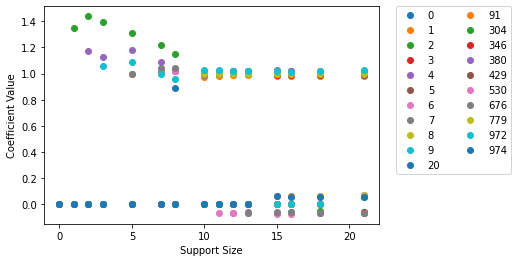

In [9]:
ax = fit_model.plot(include_legend=True)

The legend of the plot presents the variables in the order they entered the regularization path. For example, variable 7 is the first variable to enter the path, and variable 6 is the second to enter. Thus, roughly speaking, we can view the first $k$ variables in the legend as the best subset of size $k$. To show the lines connecting the points in the plot, we can set the parameter :code:`show_lines=True` in the `plot` function, i.e., call :code:`fit.plot(fit, gamma=0, show_lines=True)`. Moreover, we note that the plot function returns a [matplotlib.axes._subplots.AxesSubplot](https://pandas.pydata.org/pandas-docs/version/0.21/visualization.html) object, which can be further customized using the `matplotlib` package. In addition, both the [l0learn.models.FitModel.plot()](code.rst#l0learn.models.FitModel.plot) and [l0learn.models.CVFitModel.cv_plot()](code.rst#l0learn.models.CVFitModel.cv_plot) accept :code:`**kwargs` parameter to allow for customization of the plotting behavior.


<AxesSubplot:xlabel='Support Size', ylabel='Coefficient Value'>

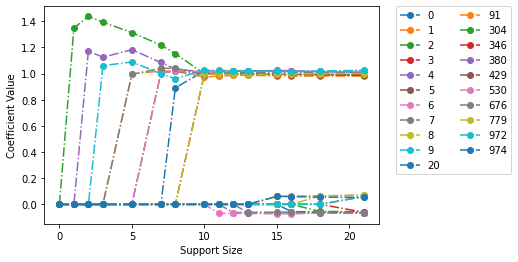

In [11]:
fit_model.plot(show_lines=True)

## Fitting L0L2 and L0L1 Regression Models
We have demonstrated the simple case of using an L0 penalty. We can also fit more elaborate models that combine L0 regularization with shrinkage-inducing penalties like the L1 norm or squared L2 norm. Adding shrinkage helps in avoiding overfitting and typically improves the predictive performance of the models. Next, we will discuss how to fit a model using the L0L2 penalty for a two-dimensional grid of :math:`\lambda` and :math:`\gamma` values. Recall that by default, `l0learn` automatically selects the :math:`\lambda` sequence, so we only need to specify the :math:`\gamma` sequence. Suppose we want to fit an L0L2 model with a maximum of 20 non-zeros and a sequence of 5 :math:`\gamma` values ranging between 0.0001 and 10. We can do so by calling [l0learn.fit](code.rst#l0learn.fit) with :code:`penalty="L0L2"`, :code:`num_gamma=5`, :code:`gamma_min=0.0001`, and :code:`gamma_max=10` as follows:

In [12]:
fit_model_2 = l0learn.fit(X, y, penalty="L0L2", num_gamma = 5, gamma_min = 0.0001, gamma_max = 10, max_support_size=20)

`l0learn` will generate a grid of 5 :math:`\gamma` values equi-spaced on the logarithmic scale between 0.0001 and 10. Similar to the case for L0, we can display a summary of the regularization path using the [l0learn.models.FitModel.characteristics](code.rst#l0learn.models.FitModel.characteristics) function as follows:

In [14]:
fit_model_2 # Using ipython Rich Display
# fit_model_2.characteristics()  # For non Rich Display

,l0,support_size,intercept,converged,l2
0,0.003788,0,-0.156704,True,10.0000
1,0.003750,1,-0.156250,True,10.0000
2,0.002911,2,-0.148003,True,10.0000
3,0.002654,3,-0.148650,True,10.0000
4,0.002597,3,-0.148650,True,10.0000
...,...,...,...,...,...
128,0.000216,10,0.002130,True,0.0001
129,0.000173,13,-0.003684,True,0.0001
130,0.000167,13,-0.003685,True,0.0001
131,0.000134,18,-0.015724,True,0.0001


The sequence of $\gamma$ values can be accessed using `fit_model_2.gamma`. To extract a solution we use the [l0learn.models.FitModel.coeff](code.rst#l0learn.models.FitModel.coeff) method. For example, extracting the solution at $\lambda=0.0016$ and $\gamma=10$ can be done using:

In [40]:
fit_model_2.coeff(lambda_0=0.0016, gamma=10)

<1001x1 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Column format>

Similarly, we can predict the response at this pair of $\lambda$ and $\gamma$ for the matrix X using

In [41]:
with np.printoptions(threshold=10):
    print(fit_model_2.predict(x=X, lambda_0=0.0016, gamma=10))

[[-0.31499242]
 [-0.3474209 ]
 [-0.23997924]
 ...
 [-0.06707991]
 [-0.18562493]
 [-0.25608131]]


The regularization path can also be plotted at a specific $\gamma$ using `fit_model_2.plot(gamma=10)`. Here we can see the influence of ratio of $\gamma$ and $\lambda$. Since $\gamma$ is so large ($10$) maintaining sparisity, then $\lambda$ can be quite small $0.0016$ which this results in a very stable estimate of the magnitude of the coeffs.

/Users/tnonet/Documents/GitHub/L0Learn/python/l0learn/models.py:438: UserWarning: Duplicate solution seen at support size 3. Plotting only first solution
  warnings.warn(f"Duplicate solution seen at support size {support_size}. Plotting only first solution")
/Users/tnonet/Documents/GitHub/L0Learn/python/l0learn/models.py:438: UserWarning: Duplicate solution seen at support size 10. Plotting only first solution
  warnings.warn(f"Duplicate solution seen at support size {support_size}. Plotting only first solution")
/Users/tnonet/Documents/GitHub/L0Learn/python/l0learn/models.py:438: UserWarning: Duplicate solution seen at support size 11. Plotting only first solution
  warnings.warn(f"Duplicate solution seen at support size {support_size}. Plotting only first solution")
/Users/tnonet/Documents/GitHub/L0Learn/python/l0learn/models.py:438: UserWarning: Duplicate solution seen at support size 12. Plotting only first solution
  warnings.warn(f"Duplicate solution seen at support size {support

<AxesSubplot:xlabel='Support Size', ylabel='Coefficient Value'>

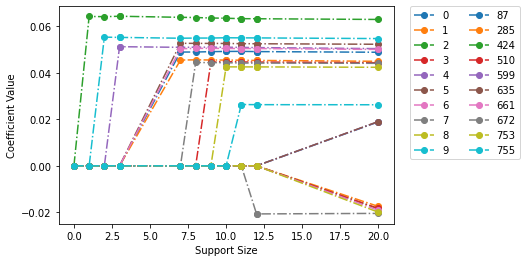

In [44]:
fit_model_2.plot(gamma=10, show_lines=True)


Finally, we note that fitting an L0L1 model can be done by just changing the `penalty` to "L0L1" in the above (in this case `gamma_max` will be ignored since it is automatically selected by the toolkit; see the reference manual for more details.)

## Higher-quality Solutions using Local Search
By default, `l0learn` uses coordinate descent (CD) to fit models. Since the objective function is non-convex, the choice of the optimization algorithm can have a significant effect on the solution quality (different algorithms can lead to solutions with very different objective values). A more elaborate algorithm based on combinatorial search can be used by setting the parameter `algorithm="CDPSI"` in the call to `l0learn.fit`. `CDPSI` typically leads to higher-quality solutions compared to CD, especially when the features are highly correlated. CDPSI is slower than CD, however, for typical applications it terminates in the order of seconds.

## Cross-validation
We will demonstrate how to use K-fold cross-validation (CV) to select the optimal values of the tuning parameters $\lambda$ and $\gamma$. To perform CV, we use the [l0learn.cvfit](code.rst#l0learn.cvfit)  function, which takes the same parameters as [l0learn.fit](code.rst#l0learn.fit), in addition to the number of folds using the `num_folds` parameter and a seed value using the `seed` parameter (this is used when randomly shuffling the data before performing CV).

For example, to perform 5-fold CV using the `L0L2` penalty (over a range of 5 `gamma` values between 0.0001 and 0.1) with a maximum of 50 non-zeros, we run:

In [45]:
cv_fit_result = l0learn.cvfit(X, y, num_folds=5, seed=1, penalty="L0L2", num_gamma=5, gamma_min=0.0001, gamma_max=0.1, max_support_size=50)

Note that the object returned during cross validation is [l0learn.models.CVFitModel](code.rst#l0learn.models.CVFitModel) which subclasses [l0learn.models.FitModel](code.rst#l0learn.models.FitModel) and thus has the same methods and underlinying structure. The cross-validation errors can be accessed using the `cv_means` attribute of a `CVFitModel`: `cv_fit_result.cv_means` is a list where the ith element, `cv_fit_result.cv_means[i]`, stores the cross-validation errors for the ith value of gamma `cv_fit_result.gamma[i]`). To find the minimum cross-validation error for every `gamma`, we apply the :code:`np.argmin` function for every element in the list :`cv_fit_result.cv_means`, as follows:

In [52]:
gamma_mins = [(i, np.argmin(cv_mean), np.min(cv_mean)) for i, cv_mean in enumerate(cv_fit_result.cv_means)]
gamma_mins

[(0, 8, 0.5313128699361661),
 (1, 8, 0.2669789604993652),
 (2, 8, 0.2558807301729078),
 (3, 20, 0.25555788170828786),
 (4, 19, 0.2555564968851251)]

The above output indicates that the 5th value of gamma achieves the lowest CV error (`=0.255`). We can plot the CV errors against the support size for the 5th value of gamma, i.e., `gamma = cv_fit_result.gamma[4]`, using:

<AxesSubplot:xlabel='Support Size', ylabel='Cross-Validation Error'>

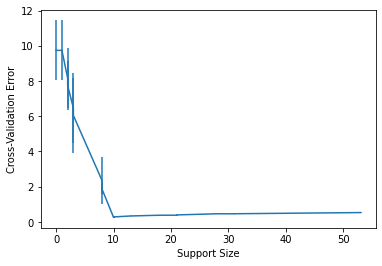

In [50]:
cv_fit_result.cv_plot(gamma = cv_fit_result.gamma[4])
cv_fit_result.cv_sds

The above plot is produced using the [matplotlib](https://pandas.pydata.org/pandas-docs/version/0.21/visualization.html) package and returns a [matplotlib.axes._subplots.AxesSubplot](https://pandas.pydata.org/pandas-docs/version/0.21/visualization.html) which can be further customized by the user. We can also note that we have error bars in the cross validation error which is stored in `cv_sds` attribute and can be accessed with  `cv_fit_result.cv_sds`. To extract the optimal $\lambda$ (i.e., the one with minimum CV error) in this plot, we execute the following:

In [57]:
optimal_gamma_index, optimal_lambda_index, min_error = min(gamma_mins, key = lambda t: t[2])
print(optimal_gamma_index, optimal_lambda_index, min_error)
print("Optimal lambda = ", fit_model_2.lambda_0[optimal_gamma_index][optimal_lambda_index])

4 19 0.2555564968851251
Optimal lambda =  0.0016080760437896327


To print the solution corresponding to the optimal gamma/lambda pair:

In [58]:
cv_fit_result.coeff(lambda_0=fit_model_2.lambda_0[optimal_gamma_index][optimal_lambda_index],
                    gamma=fit_model_2.gamma[optimal_gamma_index])

<1001x1 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Column format>

The optimal solution (above) selected by cross-validation correctly recovers the support of the true vector of coefficients used to generate the model.

In [70]:
beta_vector = cv_fit_result.coeff(lambda_0=fit_model_2.lambda_0[optimal_gamma_index][optimal_lambda_index],
                    gamma=fit_model_2.gamma[optimal_gamma_index],
                    include_intercept=False).toarray()

with np.printoptions(threshold=30, edgeitems=15):
    print(np.hstack([beta_vector, B.reshape(-1, 1)]))

[[1.01994648 1.        ]
 [0.97317979 1.        ]
 [0.99813347 1.        ]
 [0.99669481 1.        ]
 [1.01128182 1.        ]
 [1.00190748 1.        ]
 [1.01272103 1.        ]
 [0.99204841 1.        ]
 [0.99607406 1.        ]
 [1.0266543  1.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 ...
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.         0.        ]]


## Fitting Classification Models
All the commands and plots we have seen in the case of regression extend to classification. We currently support logistic regression (using the parameter `loss="Logistic"`) and a smoothed version of SVM (using the parameter `loss="SquaredHinge"`). To give some examples, we first generate a synthetic classification dataset (similar to the one we generated in the case of regression):

In [72]:
import numpy as np
np.random.seed(4) # fix the seed to get a reproducible result
n, p, k = 500, 1000, 10
X = np.random.normal(size=(n, p))
B = np.zeros(p)
B[:k] = 1
e = np.random.normal(size=(n,))/2
y = np.sign(X@B + e)

More expressive and complete functions for generating datasets can be found are available in [l0learn.models](code.rst#l0learn.models). The available functions are:

* [l0learn.models.gen_synthetic()](code.rst#l0learn.models.gen_synthetic)
* [l0learn.models.gen_synthetic_high_corr()](code.rst#l0learn.models.gen_synthetic_high_corr)
* [l0learn.models.gen_synthetic_logistic()](code.rst#l0learn.models.gen_synthetic_logistic)

An L0-regularized logistic regression model can be fit by specificying `loss = "Logistic"` as follows:

In [117]:
fit_model_3 = l0learn.fit(X,y,loss="Logistic", max_support_size=20)
fit_model_3

,l0,support_size,intercept,converged,l2
0,25.225336,1,-0.036989,True,1.000000e-07
1,19.432053,2,-0.043199,True,1.000000e-07
2,18.928603,2,-0.043230,True,1.000000e-07
3,15.142882,2,-0.043245,True,1.000000e-07
4,12.114306,9,0.004044,True,1.000000e-07
5,7.411211,10,0.188422,False,1.000000e-07
6,7.188875,10,0.219990,False,1.000000e-07
7,5.751100,10,0.234899,False,1.000000e-07
8,4.600880,10,0.242631,False,1.000000e-07
9,3.680704,10,0.243655,True,1.000000e-07


The output above indicates that $\gamma=10^{-7}$ by default we use a small ridge regularization (with $\gamma=10^{-7}$) to ensure the existence of a unique solution. To extract the coefficients of the solution with $\lambda = 8.69435$ we use the following code. Notice that we can ignore the specification of gamma as there is only one gamma used in L0 Logistic regression:

In [83]:
np.where(fit_model_3.coeff(lambda_0=7.411211).toarray() > 0)[0]

The above indicates that the 10 non-zeros in the estimated model match those we used in generating the data (i.e, L0 regularization correctly recovered the true support). We can also make predictions at the latter $\lambda$ using:

In [84]:
with np.printoptions(threshold=10):
   print(fit_model_3.predict(X, lambda_0=7.411211))

[[1.69583037e-04]
 [4.92440655e-06]
 [3.92195535e-03]
 ...
 [9.99161941e-01]
 [1.69035746e-01]
 [9.99171256e-04]]


Each row in the above is the probability that the corresponding sample belongs to class $1$. Other models (i.e., L0L2 and L0L1) can be similarly fit by specifying `loss = "Logistic"`.

Finally, we note that L0Learn also supports a smoothed version of SVM by using squared hinge loss `loss = "SquaredHinge"`. The only difference from logistic regression is that the `predict` function returns $\beta_0 + \langle x, \beta \rangle$ (where $x$ is the testing sample), instead of returning probabilities. The latter predictions can be assigned to the appropriate classes by using a thresholding function (e.g., the sign function).

## Advanced Options

### Sparse Matrix Support
Starting in version 2.0.0, L0Learn supports sparse matrices of type [scipy.sparse.csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html). If your sparse matrix uses a different storage format, please convert it to `csc_matrix` before using it in `l0learn`. `l0learn` keeps the matrix sparse internally and thus is highly efficient if the matrix is sufficiently sparse. The API for sparse matrices is the same as that of dense matrices, so all the demonstrations in this vignette also apply for sparse matrices. For example, we can fit an L0-regularized model on a sparse matrix as follows:

In [90]:
from scipy.sparse import random
from scipy.stats import norm


X_sparse = random(n, p, density=0.01, format='csc', data_rvs=norm().rvs)
y_sparse = (X_sparse@B + e)

fit_model_sparse = l0learn.fit(X_sparse, y_sparse, penalty="L0", max_support_size=20)

fit_model_sparse.characteristics()

,l0,support_size,intercept,converged
0,0.031892,0,0.009325,True
1,0.031573,1,0.004882,True
2,0.020606,2,-0.002187,True
3,0.014442,3,-0.004111,True
4,0.013932,4,-0.002556,True
5,0.010854,5,0.002987,True
6,0.009286,6,0.002048,True
7,0.009191,7,-0.001371,True
8,0.008771,8,-0.000533,True
9,0.008151,9,0.000064,True


### Selection on Subset of Variables
In certain applications, it is desirable to always include some of the variables in the model and perform variable selection on others. `l0learn` supports this option through the `exclude_first_k` parameter. Specifically, setting `exclude_first_k = K` (where K is a non-negative integer) instructs `l0learn` to exclude the first K variables in the data matrix `X` from the L0-norm penalty (those K variables will still be penalized using the L2 or L1 norm penalties.). For example, below we fit an `L0` model and exclude the first 3 variables from selection by setting `excludeFirstK = 3`:

In [94]:
fit_model_k = l0learn.fit(X, y, penalty="L0", max_support_size=10, exclude_first_k=3)
fit_model_k.characteristics()

,l0,support_size,intercept,converged
0,0.050464,3,-0.017599,True
1,0.044333,4,-0.021333,True
2,0.032770,5,-0.027624,True
3,0.029367,7,-0.029115,True
4,0.024710,8,-0.021199,True
5,0.021393,9,0.010249,True
6,0.014785,10,0.016812,True


Plotting the regularization path:

<AxesSubplot:xlabel='Support Size', ylabel='Coefficient Value'>

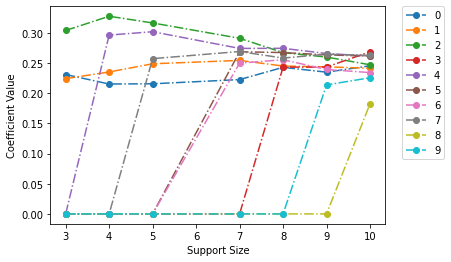

In [93]:
fit_model_k.plot(show_lines=True)

We can see in the plot above that first 3 variables, (0, 1, 2) are included in all the solutions of the path

### Coefficient Bounds
Starting in version 2.0.0, `l0learn` supports bounds for CD algorithms for all losses and penalties. (We plan to support bound constraints for the CDPSI algorithm in the future). By default, `l0learn` does not apply bounds, i.e., it assumes $-\infty <= \beta_i <= \infty$ for all i. Users can supply the same bounds for all coefficients by setting the parameters `lows` and `highs` to scalar values (these should satisfy: `lows <= 0`, `lows != highs`, and `highs >= 0`). To use different bounds for the coefficients, `lows` and `highs` can be both set to vectors of length `p` (where the i-th entry corresponds to the bound on coefficient i).

All of the following examples are valid.

In [107]:
l0learn.fit(X, y, penalty="L0", lows=-0.5)
l0learn.fit(X, y, penalty="L0", highs=0.5)
l0learn.fit(X, y, penalty="L0", lows=-0.5, highs=0.5)

max_value = 0.25
highs_array = max_value*np.ones(p)
highs_array[0] = 0.1
fit_model_bounds = l0learn.fit(X, y, penalty="L0", lows=-0.1, highs=highs_array, max_support_size=20)

We can see the coefficients are subject to the bounds.

/Users/tnonet/Documents/GitHub/L0Learn/python/l0learn/models.py:438: UserWarning: Duplicate solution seen at support size 0. Plotting only first solution
  warnings.warn(f"Duplicate solution seen at support size {support_size}. Plotting only first solution")
/Users/tnonet/Documents/GitHub/L0Learn/python/l0learn/models.py:438: UserWarning: Duplicate solution seen at support size 6. Plotting only first solution
  warnings.warn(f"Duplicate solution seen at support size {support_size}. Plotting only first solution")
/Users/tnonet/Documents/GitHub/L0Learn/python/l0learn/models.py:438: UserWarning: Duplicate solution seen at support size 8. Plotting only first solution
  warnings.warn(f"Duplicate solution seen at support size {support_size}. Plotting only first solution")


maximum value of coefficients = 0.25 <= 0.25
maximum value of first coefficient = 0.1 <= 0.1
minimum value of coefficient = -0.1 >= -0.1


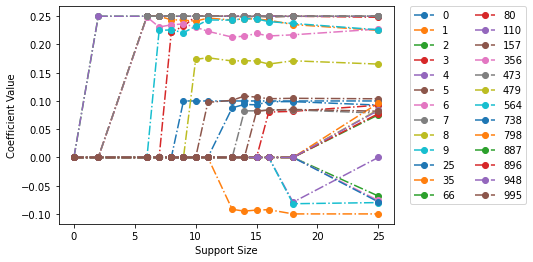

In [110]:
fit_model_bounds.plot(show_lines=True)

print(f"maximum value of coefficients = {np.max(fit_model_bounds.coeffs[0])} <= {max_value}")
print(f"maximum value of first coefficient = {np.max(fit_model_bounds.coeffs[0][0, :])} <= 0.1")
print(f"minimum value of coefficient = {np.min(fit_model_bounds.coeffs[0])} >= -0.1")


### User-specified Lambda Grids
By default, `l0learn` selects the sequence of lambda values in an efficient manner to avoid wasted computation (since close $\lambda$ values can typically lead to the same solution). Advanced users of the toolkit can change this default behavior and supply their own sequence of $\lambda$ values. This can be done supplying the $\lambda$ values through the parameter `lambda_grid`. When `lambda_grid` is supplied, we require `num_gamma` and `num_lambda` to be `None` to ensure the is no ambiguity in the solution path requested.

Specifically, the value assigned to `lambda_grid` should be a list of lists/arrays of decreasing positive values (floats). The length of `lambda_grid` (the number of lists stored) specifies the number of gamma parameters that will fill between `gamma_min`, and `gamma_max`. In the case of L0 penalty, `lambda_grid` must be a list of length 1. In case of L0L2/L0L1 `lambda_grid` can have any number of sub-lists stored. The ith element in `lambda_grid` should be a **strictly decreasing** sequence of positive lambda values which are used by the algorithm for the ith value of gamma. For example, to fit an L0 model with the sequence of user-specified lambda values: 1, 1e-1, 1e-2, 1e-3, 1e-4, we run the following:

In [113]:
user_lambda_grid = [[1, 1e-1, 1e-2, 1e-3, 1e-4]]
fit_grid = l0learn.fit(X, y, penalty="L0", lambda_grid=user_lambda_grid, max_support_size=1000, num_lambda=None, num_gamma=None)

To verify the results we print the fit object:

In [114]:
fit_grid
# Use fit_grid.characteristics() for those without rich dispalys

,l0,support_size,intercept,converged
0,1.0000,0,-0.016000,True
1,0.1000,0,-0.016000,True
2,0.0100,10,0.016811,True
3,0.0010,62,0.018729,True
4,0.0001,267,0.051675,True


Note that the $\lambda$ values above are the desired values. For L0L2 and L0L1 penalties, the same can be done where the `lambda_grid` parameter.

In [115]:
user_lambda_grid_L2 = [[1, 1e-1, 1e-2, 1e-3, 1e-4],
                       [10, 2, 1, 0.01, 0.002, 0.001, 1e-5],
                       [1e-4, 1e-5]]

# user_lambda_grid_L2[[i]] must be a sequence of positive decreasing reals.
fit_grid_L2 = l0learn.fit(X, y, penalty="L0L2", lambda_grid=user_lambda_grid_L2, max_support_size=1000, num_lambda=None, num_gamma=None)

In [116]:
fit_grid_L2
# Use fit_grid_L2.characteristics() for those without rich dispalys

,l0,support_size,intercept,converged,l2
0,1.00000,0,-0.016000,True,10.000000
1,0.10000,0,-0.016000,True,10.000000
2,0.01000,0,-0.016000,True,10.000000
3,0.00100,9,-0.014394,True,10.000000
4,0.00010,134,-0.012180,True,10.000000
5,10.00000,0,-0.016000,True,0.031623
6,2.00000,0,-0.016000,True,0.031623
7,1.00000,0,-0.016000,True,0.031623
8,0.01000,10,0.015045,True,0.031623
9,0.00200,28,0.001483,True,0.031623


# More Details
For more details please inspect the doc strings of:

* [l0learn.models.CVFitModel](code.rst#l0learn.models.CVFitModel)
* [l0learn.models.FitModel](code.rst#l0learn.models.FitModel)
* [l0learn.fit](code.rst#l0learn.fit)
* [l0learn.cvfit](code.rst#l0learn.cvfit)

# References
Hussein Hazimeh and Rahul Mazumder. [Fast Best Subset Selection: Coordinate Descent and Local Combinatorial Optimization Algorithms](https://pubsonline.informs.org/doi/10.1287/opre.2019.1919). Operations Research (2020).

Antoine Dedieu, Hussein Hazimeh, and Rahul Mazumder. [Learning Sparse Classifiers: Continuous and Mixed Integer Optimization Perspectives](https://arxiv.org/abs/2001.06471). JMLR (to appear).